# Perform one sample test in control cells

Both HBECs and PBMCs

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline

In [2]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [3]:
data_path = '/data_volume/ifn_hbec/'
fig_path = '/home/ssm-user/Github/scrna-parameter-estimation/figures/fig4/main/'

### Read the processed RNA data

Focus on the club and bc/club cells and type I interferons for now.

Encode the timestamps to integers.

In [4]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

In [5]:
adata = adata[:, ~adata.var.index.str.startswith('MT-')].copy()
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'basal/club' else 'bc')
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'ionocyte/tuft' else 'ion-tuft')

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [6]:
adata.shape

(69958, 36588)

### Setup memento

In [7]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [8]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [9]:
memento.setup_memento(adata, q_column='q')

In [10]:
adata.obs.head(3)

,NUM.SNPS,BEST.GUESS,DROPLET.TYPE,batch,HTO_classification,condition,donor,stim,time,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,cell_type,q,memento_size_factor
AAACCCAAGGAAGTAG-1,1700,donor0,SNG,0,hash-10,d2513_lambda_9,d2513,lambda,9,4297,4297,12191.0,1394.0,11.434665,3,ciliated,0.10425,0.955289
AAACCCAAGGGACTGT-1,839,donor0,SNG,0,hash-3,d2513_alpha_24,d2513,alpha,24,2171,2171,7270.0,386.0,5.309491,5,bc,0.10425,0.824407
AAACCCACAATCTGCA-1,1130,donor1,SNG,0,hash-1,d2614_alpha_3,d2614,alpha,3,3016,3016,9544.0,516.0,5.406538,0,basal,0.10425,0.988939


In [11]:
adata.uns['memento'].keys()

dict_keys(['q_column', 'all_q', 'estimator_type', 'filter_mean_thresh', 'num_bins', 'least_variable_genes', 'all_1d_moments'])

In [12]:
adata.obs.cell_type.value_counts()

bc           29792
basal        22844
ciliated     15041
goblet        1525
ion-tuft       546
neuroendo      210
Name: cell_type, dtype: int64

### Perform one sample test on ciliated, control cells

In [13]:
adata_ctrl = adata.copy()[
    adata.obs.cell_type.isin(['ciliated']) & \
    adata.obs.stim.isin(['control']), :].copy()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [14]:
memento.create_groups(adata_ctrl, label_columns=['donor'])

In [15]:
memento.compute_1d_moments(adata_ctrl, min_perc_group=.9)

In [16]:
memento.ht_1d_moments(
    adata_ctrl,
    formula_like='1',
    cov_column='Inter',
    num_boot=10000, 
    verbose=1,
    num_cpus=13)

[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    3.2s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    7.9s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   16.4s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   27.6s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   41.7s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   58.2s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.3min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.7min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  2.2min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.7min
[Parallel(n_jobs=13)]: Done 6024 tasks      | elapsed:  3.2min
[Parallel(n_jobs=13)]: Done 7174 tasks      | elapsed:  3.8min
[Parallel(n_jobs=13)]: Done 8424 tasks      | elapsed:  4.5min
[Parallel(n_jobs=13)]: Done 9774 tasks      | elapsed:  5.2min
[Parallel(n_jobs=13)]: Done 10150 out of 1015

In [17]:
onesamp_ht_df = memento.get_1d_ht_result(adata_ctrl)

In [18]:
onesamp_ht_df['dv_fdr'] = memento.util._fdrcorrect(onesamp_ht_df['dv_pval'])

In [19]:
hv_genes = onesamp_ht_df.query('dv_fdr < 0.01 & dv_coef > 0').gene.tolist()
lv_genes = onesamp_ht_df.query('dv_fdr < 0.01 & dv_coef < 0').gene.tolist()

In [20]:
len(hv_genes)

440

In [21]:
# for gene in hv_genes:
#     print(gene)

In [22]:
onesamp_ht_df.query('gene.str.contains("IFIT")', engine='python')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,dv_fdr
5204,IFIT2,-0.469849,0.126099,0.000395,2.978472,0.264624,1.078504e-07,0.000052
5205,IFIT3,-0.020981,0.074366,0.778922,2.309936,0.225425,6.870317e-07,0.000108
5206,IFIT1,0.274242,0.061957,0.000230,1.955586,0.146845,4.984959e-07,0.000095
5207,IFIT5,-1.348701,0.076424,0.000001,0.078432,0.456168,8.370163e-01,0.932878
5386,IFITM2,-0.005149,0.062607,0.937306,1.715650,0.193101,7.123121e-07,0.000108
5387,IFITM1,-0.627829,0.082347,0.000023,2.059088,0.224883,2.505188e-06,0.000199
5388,IFITM3,1.395832,0.039103,0.000039,1.245325,0.166377,4.229240e-05,0.001321
5419,IFITM10,-0.080528,0.050509,0.108989,0.986147,0.134817,5.902773e-06,0.000352


In [23]:
onesamp_ht_df.sort_values('dv_coef', ascending=False).head(20)

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,dv_fdr
9347,BPIFA1,1.711823,0.238704,0.000018,4.772759,0.172234,9.999000e-05,0.002469
5086,MSMB,2.002644,0.231054,0.000002,4.753874,0.312346,4.379301e-07,0.000095
1640,CCL20,-0.122780,0.209402,0.551445,4.453336,0.179883,1.519361e-09,0.000015
5618,SCGB1A1,1.821146,0.175603,0.000003,4.449934,0.141542,3.148436e-08,0.000040
9591,TFF3,1.162709,0.202194,0.000041,4.414665,0.411295,2.943040e-07,0.000081
9348,BPIFB1,2.132191,0.159822,0.000005,4.029002,0.149955,1.064751e-06,0.000121
2800,CDC20B,-0.837752,0.204773,0.001500,3.995393,0.100496,5.251534e-07,0.000097
5416,MUC5B,-0.609397,0.175654,0.002800,3.798337,0.193125,6.307965e-06,0.000364
6281,TSPAN8,-1.275266,0.223518,0.000113,3.763758,0.451287,1.471564e-07,0.000057
2802,CCNO,0.747182,0.125048,0.000037,3.682878,0.095809,4.618818e-07,0.000095


In [24]:
hbec_1d = onesamp_ht_df[['gene', 'dv_coef']].copy()

In [25]:
with open('hv_genes.pkl', 'wb') as f:
    pkl.dump(hv_genes, f)

### Enrichment for HBECs

In [26]:
import gseapy as gp

In [27]:
# enr = gp.enrichr(
#     gene_list=hv_genes,
#     gene_sets=['KEGG_2016'],
#     organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
#     description='test_name',
#     outdir='./gsea/',
#     # no_plot=True,
#     cutoff=0.5 # test dataset, use lower value from range(0,1)
#     )

enr2 = gp.enrichr(
    gene_list=hv_genes,
    gene_sets=['Reactome_2016'],
    organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
    description='test_name',
    outdir='./gsea/',
    # no_plot=True,
    cutoff=0.5 # test dataset, use lower value from range(0,1)
    )

In [28]:
df = enr2.results.sort_values('Adjusted P-value').head(50)
df['log_p'] = -np.log10(df['P-value'])
df['term'] = df['Term'].apply(lambda x : ' '.join(x.split(' ')[:-3]))
df['term'] = df['term'].apply(lambda x: x if len(x.split(' ')) < 4 else ' '.join(x.split(' ')[:2]) + '\n'+ ' '.join(x.split(' ')[2:]))

In [29]:
df.head(30)[['term', 'Adjusted P-value']]

,term,Adjusted P-value
0,Interferon alpha/beta signaling,3.493558e-12
1,Interferon Signaling,7.829118e-11
2,Cellular Senescence,2.502550e-05
3,TP53 Regulates\nTranscription of Cell Cycle Genes,1.329037e-04
4,Senescence-Associated Secretory\nPhenotype (SASP),1.329037e-04
5,Cytokine Signaling\nin Immune system,1.329037e-04
6,RHO GTPases\nactivate PKNs,5.044572e-03
8,Translocation of\nZAP-70 to Immunological synapse,6.214028e-03
7,Cellular responses\nto stress,6.214028e-03
9,Phosphorylation of\nCD3 and TCR zeta chains,1.037117e-02


In [30]:
# plt.figure(figsize=(2, 3))
# sns.barplot(x='log_p', y='term', data=df.head(15), palette='Set2')
# plt.ylabel(None); plt.xlabel('-log P')

# plt.savefig(fig_path + 'enrichment.pdf', bbox_inches='tight')


In [31]:
gene_set_hits = df.head(10)['Genes']
gene_set_hits = [x.split(';') for x in gene_set_hits]

### Mean vs variability plots for ctrl cells

In [32]:
m_df, v_df = memento.get_1d_moments(adata_ctrl, groupby='ALL')

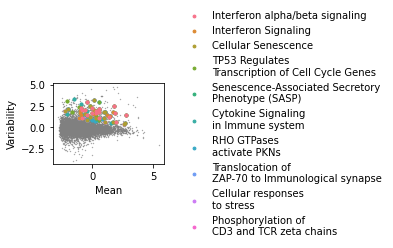

In [34]:
plt.figure(figsize=(2, 1.5))
plt.scatter(m_df['ALL_sg'], v_df['ALL_sg'], s=0.1,color='gray')
# plt.scatter(m_df.query('gene in @hv_genes')['ALL_sg'], v_df.query('gene in @hv_genes')['ALL_sg'], s=0.2,color='k')


for gene_set, label, color in zip(gene_set_hits, df.head(10)['term'].tolist(), sns.color_palette('husl', 10)):
    plt.scatter(
        m_df.query('gene in @gene_set')['ALL_sg'], 
        v_df.query('gene in @gene_set')['ALL_sg'], 
        s=8,color=color, label=label)
    
for gene_set, label, color in zip(gene_set_hits[::-1], df.head(10)['term'].tolist()[::-1], sns.color_palette('husl', 10)[::-1]):
    plt.scatter(
        m_df.query('gene in @gene_set')['ALL_sg'], 
        v_df.query('gene in @gene_set')['ALL_sg'], 
        s=8,color=color)

plt.xlabel('Mean'); plt.ylabel('Variability');
plt.legend(loc='center left', frameon=False, bbox_to_anchor=(1.1,0.5))
plt.savefig(fig_path + 'm_vs_v_onesamp_enrich.png', bbox_inches='tight', dpi=300)


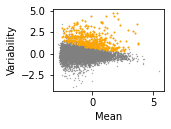

In [146]:
plt.figure(figsize=(2, 1.5))
plt.scatter(m_df['ALL_sg'], v_df['ALL_sg'], s=0.1,color='gray')
plt.scatter(m_df.query('gene in @hv_genes')['ALL_sg'], v_df.query('gene in @hv_genes')['ALL_sg'], s=1,color='orange')
plt.xlabel('Mean'); plt.ylabel('Variability');
plt.savefig(fig_path + 'm_vs_v_onesamp.png', bbox_inches='tight', dpi=300)


### Compare to naive estimators


In [61]:
adata_ctrl = adata.copy()[
    adata.obs.cell_type.isin(['ciliated']) & \
    adata.obs.stim.isin(['control']), :].copy()
adata_ctrl.obs['group'] = 'A'

In [62]:
memento.create_groups(adata_ctrl, label_columns=['group'])

In [63]:
memento.compute_1d_moments(adata_ctrl, min_perc_group=.9)

In [64]:
sf = adata_ctrl.obs['memento_size_factor'].values

In [65]:
naive_m = (adata_ctrl.X/sf.reshape(-1, 1)).mean(axis=0).A1
naive_v = (adata_ctrl.X/sf.reshape(-1, 1)).var(axis=0).A1

In [67]:
memento_m, memento_v, _ = adata_ctrl.uns['memento']['1d_moments']['sg^A']

In [70]:
memento_cv = memento_v/memento_m**2
naive_cv = naive_v/naive_m**2

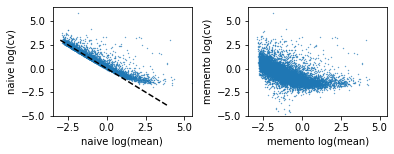

In [92]:
plt.figure(figsize=(6, 2));
plt.subplots_adjust(wspace=0.4)
plt.subplot(1, 2, 1);
plt.scatter(np.log(naive_m), np.log(naive_cv), s=0.1)
plt.plot([-3, 4], [3, -4], '--',color='k')
plt.xlabel('naive log(mean)'); plt.ylabel('naive log(cv)')
plt.xlim(-3.5, 5.5); plt.ylim(-5, 6.5)
plt.subplot(1, 2, 2);
plt.scatter(np.log(memento_m), np.log(memento_cv), s=0.1)
plt.xlim(-3.5, 5.5); plt.ylim(-5, 6.5)
plt.xlabel('memento log(mean)'); plt.ylabel('memento log(cv)')

fig_path = '/home/ssm-user/Github/scrna-parameter-estimation/figures/fig4/main/'
plt.savefig(fig_path + 'm_vs_cv.png', bbox_inches='tight', dpi=300)


In [54]:
naive_m

array([0.12720141, 0.111439  , 0.31076068, ..., 0.07160998, 0.23941539,
       0.12352613], dtype=float32)

In [39]:
memento_m = memento_m['ALL_sg'].values

,gene,ALL_sg
0,LINC01409,-2.073328
1,FAM41C,-2.194538
2,NOC2L,-1.177516
3,HES4,0.790288
4,ISG15,1.825076
...,...,...
10145,BRCC3,-1.815602
10146,VBP1,-1.051313
10147,TMLHE,-2.636638
10148,VAMP7,-1.429572


### Check the result in PBMCs

In [53]:
fig_path = '/home/ssm-user/Github/scrna-parameter-estimation/figures/fig4/supp/'
data_path = '/data_volume/parameter_estimation/'

#### Read PBMC dataset and setup memento

In [84]:
cts = ['CD4 T cells',  'CD14+ Monocytes', 'FCGR3A+ Monocytes', 'NK cells','CD8 T cells', 'B cells']
label_converter = dict(zip(cts, ['Th', 'cM', 'ncM', 'NK', 'Tc', 'B']))

In [85]:
def simplify_name(name):
    return name.split('.')[0]

In [86]:
adata = sc.read(data_path + 'interferon_filtered.h5ad')

In [87]:
adata.obs['q'] = 0.07

In [88]:
memento.setup_memento(adata, q_column='q', trim_percent=0.1)

#### Isolate the control cells and perform one sample test

In [89]:
adata_ctrl = adata.copy()[(adata.obs['cell']=='CD14+ Monocytes') & (adata.obs['stim']=='ctrl')].copy()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [90]:
adata_ctrl.obs.head(2)

,tsne1,tsne2,ind,stim,cluster,cell,multiplets,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,cell_type,q,memento_size_factor
index,,,,,,,,,,,,,,,,,,,,
AAACATACATTTCC-1,-27.640373,14.966629,1016,ctrl,9,CD14+ Monocytes,singlet,878,6.778785,3018.0,8.012681,0.0,0.0,0.0,0.0,0.0,0.0,CD14+ Monocytes - ctrl,0.07,1.385846
AAACATACCAGAAA-1,-27.493646,28.924885,1256,ctrl,9,CD14+ Monocytes,singlet,713,6.570883,2481.0,7.816820,0.0,0.0,0.0,0.0,0.0,0.0,CD14+ Monocytes - ctrl,0.07,0.879082


In [91]:
memento.create_groups(adata_ctrl, label_columns=['ind'])

In [92]:
memento.compute_1d_moments(adata_ctrl, min_perc_group=.7)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.8.egg/memento/estimator.py:105: RuntimeWarning: invalid value encountered in log


In [93]:
memento.ht_1d_moments(
    adata_ctrl,
    formula_like='1',
    cov_column='Inter',
    num_boot=10000, 
    verbose=1,
    num_cpus=13)

[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    4.3s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:   12.9s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   26.0s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   45.7s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:  1.2min
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:  1.7min
[Parallel(n_jobs=13)]: Done 2021 out of 2021 | elapsed:  1.9min finished


In [94]:
onesamp_ht_df = memento.get_1d_ht_result(adata_ctrl)

In [95]:
onesamp_ht_df['dv_fdr'] = memento.util._fdrcorrect(onesamp_ht_df['dv_pval'])

In [96]:
hv_genes = onesamp_ht_df.query('dv_fdr < 0.001 & dv_coef > 0').gene.tolist()
lv_genes = onesamp_ht_df.query('dv_fdr < 0.001 & dv_coef < 0').gene.tolist()

In [97]:
# for gene in hv_genes:
#     print(gene)

In [98]:
m_df, v_df = memento.get_1d_moments(adata_ctrl, groupby='ALL')

In [99]:
onesamp_ht_df.query('dv_coef > 0 & dv_fdr < 0.001')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,dv_fdr
0,ISG15,-0.301215,0.073202,2.603442e-04,3.099299,0.238285,2.511016e-08,0.000004
29,ID3,-1.458012,0.063831,4.963911e-07,1.945790,0.147945,1.383257e-07,0.000014
31,FUCA1,-0.903557,0.050925,4.478089e-07,1.697198,0.113328,6.110049e-08,0.000008
37,CD52,-1.508192,0.050098,2.894325e-05,1.057352,0.147558,2.302320e-05,0.000358
41,IFI6,-1.168249,0.054440,9.685842e-08,1.213305,0.162400,5.489053e-05,0.000664
...,...,...,...,...,...,...,...,...
1950,SDF2L1,-1.058585,0.045258,4.370307e-06,1.255319,0.114623,1.020194e-06,0.000052
1959,OSM,-0.922865,0.044380,4.101538e-07,1.394897,0.088016,3.403705e-06,0.000104
1964,HMOX1,-0.622214,0.037269,3.050530e-07,1.244903,0.126511,1.852529e-06,0.000076
1978,APOBEC3A,-0.916296,0.056855,1.567491e-06,1.916624,0.101642,2.420329e-08,0.000004


In [100]:
pbmc_1d = onesamp_ht_df[['gene', 'dv_coef', 'dv_fdr']].copy()

In [101]:
joined = pbmc_1d.merge(hbec_1d, on='gene', suffixes=('_pbmc', '_hbec'))

In [102]:
stats.pearsonr(joined['dv_coef_pbmc'], joined['dv_coef_hbec'])

(0.44610245884110233, 3.891042986657346e-83)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/seaborn/regression.py:422: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line, = ax.plot(grid, yhat, **kws)


Text(0, 0.5, 'HBEC variability')

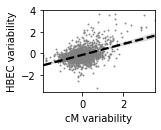

In [103]:
plt.figure(figsize=(2, 1.5))
sns.regplot(joined['dv_coef_pbmc'], joined['dv_coef_hbec'], scatter_kws={'s':1, 'color':'gray'}, line_kws={'lineStyle':'--', 'color':'k'})
# plt.scatter(joined['dv_coef_pbmc'], joined['dv_coef_hbec'], s=1, color='k')
plt.xlabel('cM variability'); plt.ylabel('HBEC variability')
# plt.savefig(fig_path + 'pbmc_vs_hbec_var.png', bbox_inches='tight', dpi=300)


In [104]:
joined['diff'] = (joined['dv_coef_pbmc']-joined['dv_coef_hbec']).abs()

In [105]:
joined.query('dv_coef_hbec > 1.5').sort_values('diff', ascending=True).head(30)

,gene,dv_coef_pbmc,dv_fdr,dv_coef_hbec,diff
1648,APOBEC3A,1.916624,0.000004,1.910602,0.006022
903,DDIT4,2.204150,0.000075,2.123719,0.080430
579,HLA-DPA1,1.466150,0.000004,1.582071,0.115921
580,HLA-DPB1,1.366849,0.000023,1.501768,0.134919
791,FABP5,2.400468,0.000024,2.634875,0.234407
773,IDO1,2.874537,0.000007,2.468887,0.405650
418,CXCL1,3.536440,0.000004,3.125915,0.410524
35,IFI6,1.213305,0.000664,1.644678,0.431373
1442,SERPINB2,2.856501,0.000021,2.349773,0.506728
419,CXCL3,3.044878,0.000014,3.573302,0.528424


### Enrichment for PBMCs

In [106]:
import gseapy as gp

In [107]:
# enr = gp.enrichr(
#     gene_list=hv_genes,
#     gene_sets=['KEGG_2016'],
#     organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
#     description='test_name',
#     outdir='./gsea/',
#     # no_plot=True,
#     cutoff=0.5 # test dataset, use lower value from range(0,1)
#     )

enr2 = gp.enrichr(
    gene_list=hv_genes,
    gene_sets=['Reactome_2016'],
    organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
    description='test_name',
    outdir='./gsea/',
    # no_plot=True,
    cutoff=0.5 # test dataset, use lower value from range(0,1)
    )

In [108]:
df = enr2.results.sort_values('Adjusted P-value').head(50)
df['log_p'] = -np.log10(df['P-value'])
df['term'] = df['Term'].apply(lambda x : ' '.join(x.split(' ')[:-3]))
df['term'] = df['term'].apply(lambda x: x if len(x.split(' ')) < 4 else ' '.join(x.split(' ')[:2]) + '\n'+ ' '.join(x.split(' ')[2:]))

In [109]:
df.head(30)[['term', 'Adjusted P-value']]

,term,Adjusted P-value
0,Chemokine receptors\nbind chemokines,1.239885e-10
1,MHC class\nII antigen presentation,1.507587e-10
2,Immune System,5.499280e-10
3,Peptide ligand-binding receptors,2.215404e-07
4,Translocation of\nZAP-70 to Immunological synapse,7.219006e-07
5,Phosphorylation of\nCD3 and TCR zeta chains,1.465705e-06
6,Interferon Signaling,1.611201e-06
7,Cytokine Signaling\nin Immune system,1.625625e-06
8,PD-1 signaling,1.651602e-06
9,Generation of\nsecond messenger molecules,9.932209e-06


In [110]:
gene_set_hits = df.head(10)['Genes']
gene_set_hits = [x.split(';') for x in gene_set_hits]

In [111]:
m_df, v_df = memento.get_1d_moments(adata_ctrl, groupby='ALL')

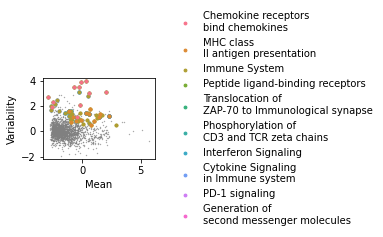

In [112]:
plt.figure(figsize=(2, 1.5))
plt.scatter(m_df['ALL_sg'], v_df['ALL_sg'], s=0.1,color='gray')
# plt.scatter(m_df.query('gene in @hv_genes')['ALL_sg'], v_df.query('gene in @hv_genes')['ALL_sg'], s=0.2,color='k')


for gene_set, label, color in zip(gene_set_hits, df.head(10)['term'].tolist(), sns.color_palette('husl', 10)):
    plt.scatter(
        m_df.query('gene in @gene_set')['ALL_sg'], 
        v_df.query('gene in @gene_set')['ALL_sg'], 
        s=8,color=color, label=label)
    
for gene_set, label, color in zip(gene_set_hits[::-1], df.head(10)['term'].tolist()[::-1], sns.color_palette('husl', 10)[::-1]):
    plt.scatter(
        m_df.query('gene in @gene_set')['ALL_sg'], 
        v_df.query('gene in @gene_set')['ALL_sg'], 
        s=8,color=color)

plt.xlabel('Mean'); plt.ylabel('Variability');
plt.legend(loc='center left', frameon=False, bbox_to_anchor=(1.1,0.5))
plt.savefig(fig_path + 'm_vs_v_onesamp_enrich_pbmc.png', bbox_inches='tight', dpi=300)


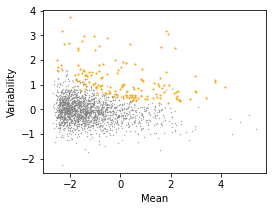

In [38]:
plt.figure(figsize=(4, 3))
plt.scatter(m_df['ALL_sg'], v_df['ALL_sg'], s=0.1,color='gray')
plt.scatter(m_df.query('gene in @hv_genes')['ALL_sg'], v_df.query('gene in @hv_genes')['ALL_sg'], s=1,color='orange')
plt.xlabel('Mean'); plt.ylabel('Variability');
plt.savefig(fig_path + 'm_vs_v_onesamp_pbmc.png', bbox_inches='tight', dpi=300)


In [36]:
onesamp_ht_df.sort_values('dv_coef', ascending=False).head(20)

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,dv_fdr
295,IL1B,-2.010218,0.200637,1.685939e-05,3.740840,0.342575,9.414523e-10,9.122672e-07
280,GNLY,-2.336887,0.178715,1.062464e-06,3.196390,0.338151,3.151618e-07,2.035945e-05
1599,CCL4,1.829208,0.060254,1.891437e-08,3.194377,0.103889,1.022157e-08,3.170909e-06
1598,CCL3,1.894398,0.051078,8.075448e-10,3.052662,0.159610,2.131682e-07,1.530074e-05
1509,NUPR1,-1.053738,0.088842,1.710292e-04,2.981152,0.126372,1.002254e-07,9.249370e-06
1102,HBB,-1.452393,0.136822,8.506516e-06,2.978186,0.420924,2.290646e-08,3.170909e-06
489,CXCL3,-0.541382,0.079517,4.171528e-04,2.900144,0.106330,6.977687e-07,3.467374e-05
1605,CCR7,-1.555124,0.093630,1.050379e-06,2.783267,0.200630,2.216089e-08,3.170909e-06
1600,CCL3L1,-2.046472,0.123018,1.458550e-06,2.684193,0.262395,6.184054e-07,3.153867e-05
487,IL8,0.399955,0.052920,5.748862e-06,2.666414,0.081006,7.954302e-08,8.113388e-06


In [29]:
onesamp_ht_df.query('gene.str.contains("IFIT")', engine='python')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,dv_fdr
1062,IFIT2,2.123506,0.016047,2.519822e-10,0.664085,0.053250,8.676343e-06,0.000155
1063,IFIT3,2.360893,0.014359,4.376796e-06,0.343397,0.039582,9.831944e-06,0.000171
1064,IFIT1,2.250409,0.014361,1.355806e-10,0.424394,0.039500,1.182113e-05,0.000194
1065,IFIT5,-1.460855,0.051044,1.509962e-07,0.025312,0.247138,9.143086e-01,0.956234
1086,IFITM2,1.065460,0.015153,1.328423e-05,-0.423400,0.076280,8.121454e-05,0.000865
1087,IFITM1,-1.098009,0.036997,1.352632e-08,-0.647516,0.259061,3.449655e-02,0.130320
1088,IFITM3,2.743918,0.007590,1.333677e-06,-1.239418,0.054461,4.073864e-07,0.000025
